# Sentiment Analysis using Amazon Fine Food Reviews



## Import data

In [2]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os

For the data, you can click download at
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Or you can download it by the following cell:

In [4]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Remeber to change the path here for the corresponding files you need
df = pd.read_csv('Reviews.csv')
print(df.shape)

(568454, 10)


In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Text Cleaning


In [7]:
#https://www.kaggle.com/code/namansood/vanilla-ml-models-for-nlp-guide
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords


# Lowercase
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Remove punctuation
df['Text'] = df['Text'].str.replace('[^\w\s]', "")
df['Text'].head()

print(df['Text'][5])

<ipython-input-7-04d43c6f7acd>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]', "")


i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much redblack licoriceflavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy  it was a delightful treat


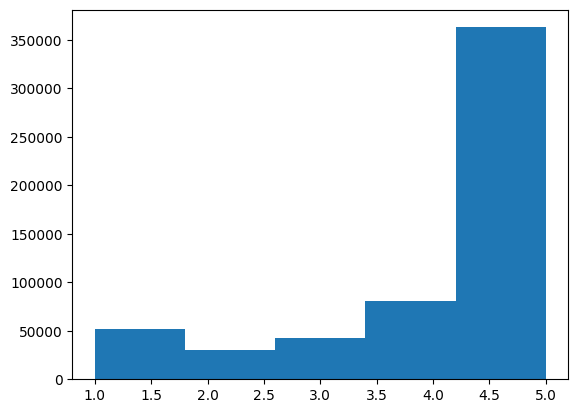

In [8]:
df.dropna(inplace=True)
df.Score.hist(bins=5, grid=False)
plt.show()

In [9]:
# Use a smaller sample
score1 = df[df['Score']==1].sample(n=800)
score2 = df[df['Score']==2].sample(n=800)
score3 = df[df['Score']==3].sample(n=800)
score4 = df[df['Score']==4].sample(n=800)
score5 = df[df['Score']==5].sample(n=800)

small_df = pd.concat([score1, score2, score3, score4, score5], axis=0)
print(small_df.head())

            Id   ProductId          UserId        ProfileName  \
229425  229426  B000FK5O0G  A29RWO2UB6E2KB  Tabitha R. Teeter   
293429  293430  B000ILILM0  A15Q7O6FVGD5L8         Dobro Song   
244803  244804  B0024VCRCM   AOT6Y0S6FYQSG              shibi   
567881  567882  B005K4Q68Q  A3D9XTM4L39OJN              james   
216741  216742  B000Q92QIE  A1GEIPO2O5CS18               blue   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
229425                     0                       0      1  1276992000   
293429                     0                       0      1  1310169600   
244803                     2                       6      1  1283126400   
567881                     1                       1      1  1324252800   
216741                     0                      12      1  1242345600   

                                                  Summary  \
229425                            Texture like beef jerky   
293429                              

# Word2vec

### Imports

In [10]:
#https://www.kaggle.com/code/aayushkubba/word2vec-and-random-forest-classification

from gensim.models import Word2Vec, word2vec
from gensim.test.utils import common_texts, lee_corpus_list
import logging
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import sqlite3
import re
from tqdm import tqdm

# Load the punkt tokenizer used for splitting reviews into sentences
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Getting original model


#model = Word2Vec(sentences=common_texts, vector_size=50, window=5, min_count=1, workers=4)
#model.save("word2vec.model")

import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")


vector = word_vectors['cat']
print(vector)

[ 0.23088    0.28283    0.6318    -0.59411   -0.58599    0.63255
  0.24402   -0.14108    0.060815  -0.7898    -0.29102    0.14287
  0.72274    0.20428    0.1407     0.98757    0.52533    0.097456
  0.8822     0.51221    0.40204    0.21169   -0.013109  -0.71616
  0.55387    1.1452    -0.88044   -0.50216   -0.22814    0.023885
  0.1072     0.083739   0.55015    0.58479    0.75816    0.45706
 -0.28001    0.25225    0.68965   -0.60972    0.19578    0.044209
 -0.31136   -0.68826   -0.22721    0.46185   -0.77162    0.10208
  0.55636    0.067417  -0.57207    0.23735    0.4717     0.82765
 -0.29263   -1.3422    -0.099277   0.28139    0.41604    0.10583
  0.62203    0.89496   -0.23446    0.51349    0.99379    1.1846
 -0.16364    0.20653    0.73854    0.24059   -0.96473    0.13481
 -0.0072484  0.33016   -0.12365    0.27191   -0.40951    0.021909
 -0.6069     0.40755    0.19566   -0.41802    0.18636   -0.032652
 -0.78571   -0.13847    0.044007  -0.084423   0.04911    0.24104
  0.45273   -0.18682 

### Getting word/sentence vectors

In [12]:
# Adapted from: https://www.kaggle.com/code/mharika/vectorization-on-amazon-fine-food-reviews/notebook
from gensim.models import KeyedVectors

list_of_sent=[]
for sent in df['Text'].values:
    list_of_sent.append(sent.split())

sent_vectors = []
i = 0
for sent in list_of_sent:
    sent_vec = np.zeros(100)
    cnt_words = 0
    for word in sent:
        try:
            vec = word_vectors[word]
            sent_vec = sent_vec + vec
            cnt_words +=1
        except KeyError:
            continue
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    if i < 10:
        print(i, " sentences processed")
    if i % 50000 == 0:
        print(i, " sentences processed")
    i += 1

0  sentences processed
0  sentences processed
1  sentences processed
2  sentences processed
3  sentences processed
4  sentences processed
5  sentences processed
6  sentences processed
7  sentences processed
8  sentences processed
9  sentences processed
50000  sentences processed
100000  sentences processed
150000  sentences processed
200000  sentences processed
250000  sentences processed
300000  sentences processed
350000  sentences processed
400000  sentences processed
450000  sentences processed
500000  sentences processed
550000  sentences processed


In [13]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

w2v_df = pd.DataFrame(sent_vectors)
w2v_df['Score'] = df['Score'].values.tolist()
w2v_df.dropna()

X = w2v_df.iloc[:, :-1].values
y = w2v_df.iloc[:, -1].values

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X, y, test_size=0.33, random_state = 42)

## Multiclass Classification

1.2686793270203218


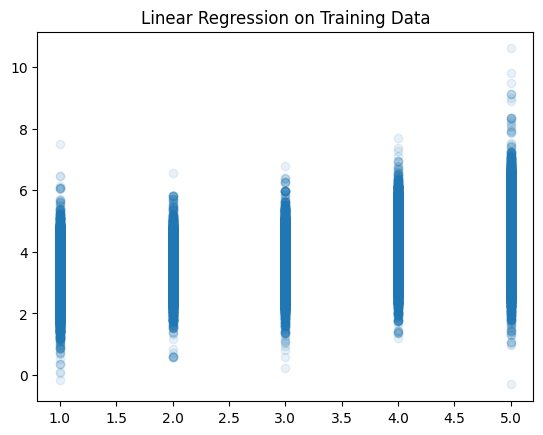

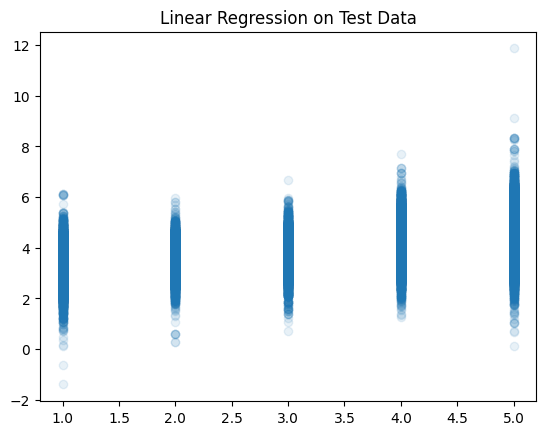

In [13]:
# Linear Regression model
from sklearn.metrics import accuracy_score

reg = LinearRegression()
reg.fit(X_train_w2v,y_train_w2v)
y_pred_w2v = reg.predict(X_test_w2v)

y_pred_train_w2v = reg.predict(X_train_w2v)

MSE = mean_squared_error(y_test_w2v, y_pred_w2v)
#accuracy = accuracy_score(y_test_w2v, y_pred_w2v)
print(MSE)


#df.Score.hist(bins=5, grid=False)
#plt.show()
plt.scatter(y_train_w2v, y_pred_train_w2v, alpha = 0.1)
plt.title("Linear Regression on Training Data")
plt.show()

plt.scatter(y_test_w2v, y_pred_w2v, alpha = 0.1)
plt.title("Linear Regression on Test Data")
plt.show()

0.6120452509915981


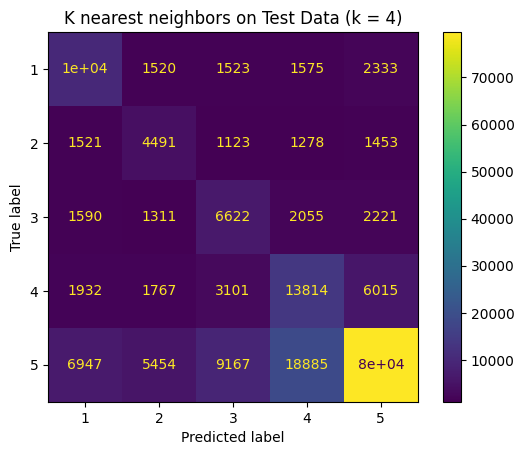

In [18]:
# K Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

k = 2
# k = 4, 0.66 accuracy
# k = 10, 0.66 accuracy, took ~14 min to run
# k = 2, 0.61 accuracy
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_w2v, y_train_w2v)

y_pred_knn = neigh.predict(X_test_w2v)

accuracy = accuracy_score(y_test_w2v, y_pred_knn)
print(accuracy)

#df.Score.hist(bins=5, grid=False)
#plt.show()

#plt.scatter(y_test_w2v, y_pred_knn, alpha = 0.1)
#plt.show()

cm_test = confusion_matrix(y_test_w2v, y_pred_knn, labels=[1,2,3,4,5])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1,2,3,4,5])
disp_test.plot()
plt.title("K nearest neighbors on Test Data (k = 4)")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 32.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   43.5s finished


Training: 0.938023028345609, Test: 0.7693788117882885


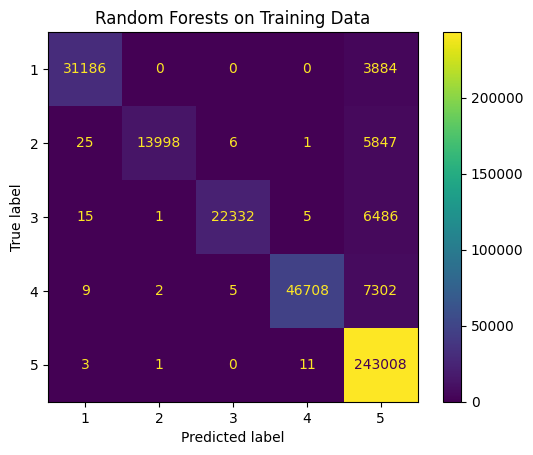

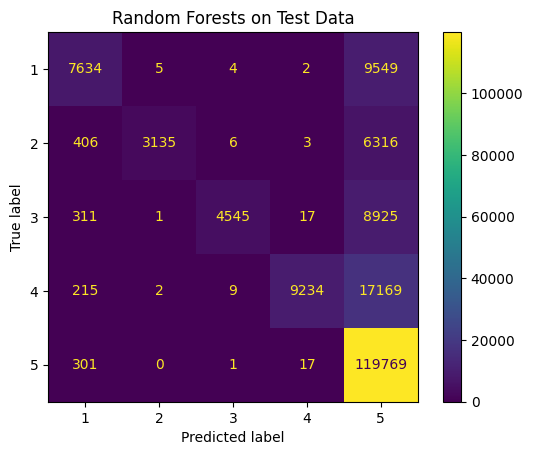

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

forest = RandomForestClassifier(n_estimators = 200, min_samples_split=15, verbose = 1)
# n_estimators = 100, accuracy = .78
# n_estimators = 200, accuracy = .78, took ~22 min to run
# n_estimators = 200, min_samples_split = 15: accuracy = 0.769, took ~34 min to run


forest.fit(X_train_w2v,y_train_w2v)
y_pred_forest = forest.predict(X_test_w2v)
y_pred_train_forest = forest.predict(X_train_w2v)

train_accuracy = accuracy_score(y_train_w2v, y_pred_train_forest)
accuracy = accuracy_score(y_test_w2v, y_pred_forest)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

cm_train = confusion_matrix(y_train_w2v, y_pred_train_forest, labels=[1,2,3,4,5])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[1,2,3,4,5])
disp_train.plot()
plt.title("Random Forests on Training Data")
plt.show()

cm_test = confusion_matrix(y_test_w2v, y_pred_forest, labels=[1,2,3,4,5])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1,2,3,4,5])
disp_test.plot()
plt.title("Random Forests on Test Data")
plt.show()

n_estimators = 100: Training: 0.9997610513739545, Test: 0.7809847741715358
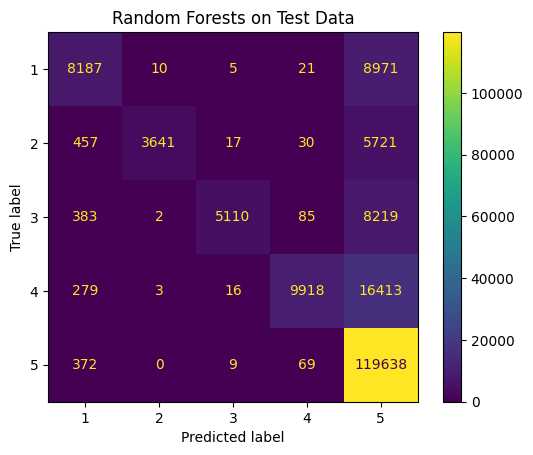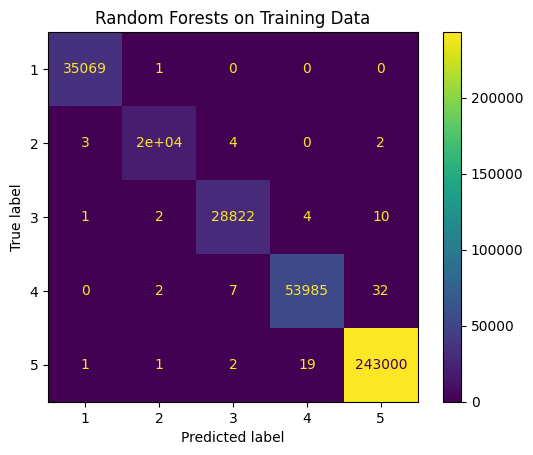

Training: 0.9997610513739545, Test: 0.7809847741715358


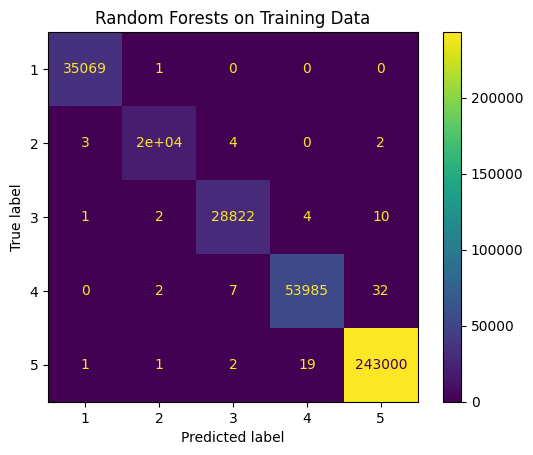

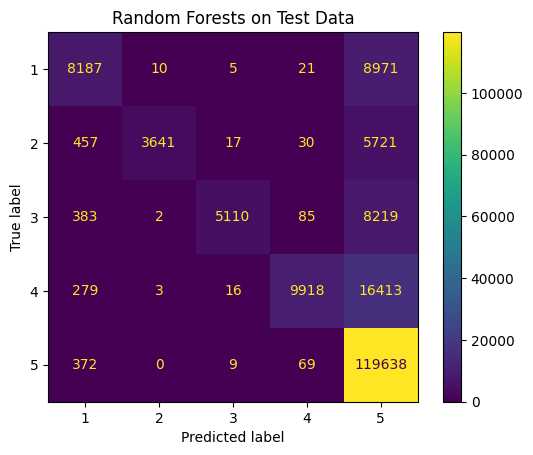

In [21]:
train_accuracy = accuracy_score(y_train_w2v, y_pred_train_forest)
accuracy = accuracy_score(y_test_w2v, y_pred_forest)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

cm_train = confusion_matrix(y_train_w2v, y_pred_train_forest, labels=[1,2,3,4,5])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[1,2,3,4,5])
disp_train.plot()
plt.title("Random Forests on Training Data")
plt.show()

cm_test = confusion_matrix(y_test_w2v, y_pred_forest, labels=[1,2,3,4,5])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1,2,3,4,5])
disp_test.plot()
plt.title("Random Forests on Test Data")
plt.show()

#plt.scatter(y_train_w2v, y_pred_train_forest, alpha = 0.1)
#plt.show()

#plt.scatter(y_test_w2v, y_pred_forest, alpha = 0.1)
#plt.show()

[18:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

MSE: 1.19417729347038
Training: 0.9510129058516156, Test: 0.7601932016889155


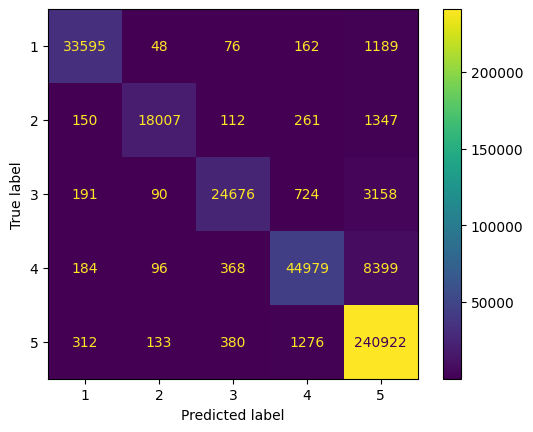

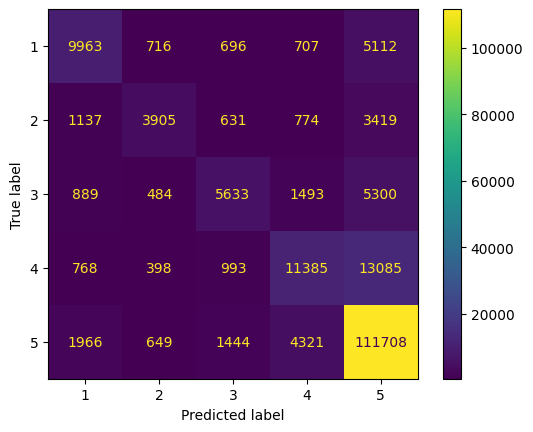

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# try 2000 max_depth
# try min samples
# try 500 estimators

bst = XGBClassifier(n_estimators=30, max_depth=10, learning_rate=1, objective='multi:softprob', verbose = 1)
# n_estimators = 10, max_depth = 30: overfit, took ~24 minutes to run
# n_estimators = 20, max_depth = 15: overfit, took ~40 minutes to run. Accuracy: 0.02
# n_estimators = 20, max_depth = 5: overfit??? Accuracy: 0.02
# n_estimators = 20, max_depth = 100: overfit, took 1 hr to run. Accuracy: 0.02
# n_estimators = 100, max_depth = 5: still overfit, took 57 min to run, Accuracy: 0.033
# n_estimators = 200, max_depth = 5, overfit, took 1 hr 53 min to run, accuracy: Training: 0.8282904670001444, Test: 0.03571885529065552
# n_estimators = 5, max_depth = 5: overfit, took 4 min to run 1% accuracy
# I was using the wrong equation for accuracy 
# n_estimators = 5, max_depth = 5: Training: 0.6572951540693476, Test: 0.6562939821725594
# n_estimators = 20, max_depth = 15: slightly overfit, took 51 min to run. Training: 0.999763677183032, Test: 0.7740915682176824
# n_estimators = 20, max_depth = 5: Training: 0.6898499350112254, Test: 0.6770162494135711, took 13 min to run
# n_estimators = 20, max_depth = 30: Training: 0.999763677183032, Test: 0.7759574785686868, took 1h 6 min to run
# n_estimators = 30, max_depth = 10: Training: 0.9510129058516156, Test: 0.7601932016889155, took 45 min to run



# fit model
new_y_train = y_train_w2v -1
new_y_test = y_test_w2v -1

bst.fit(X_train_w2v, new_y_train)
# make predictions
y_pred_w2v = bst.predict(X_test_w2v) + 1
y_pred_train_bst = bst.predict(X_train_w2v) + 1


MSE = mean_squared_error(y_test_w2v, y_pred_w2v)
print("MSE: " + str(MSE))
train_accuracy = accuracy_score(y_train_w2v, y_pred_train_bst)
accuracy = accuracy_score(y_test_w2v, y_pred_w2v)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

# Plots
cm_train = confusion_matrix(y_train_w2v, y_pred_train_bst, labels=[1,2,3,4,5])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[1,2,3,4,5])
disp_train.plot()
plt.show()

cm_test = confusion_matrix(y_test_w2v, y_pred_w2v, labels=[1,2,3,4,5])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1,2,3,4,5])
disp_test.plot()
plt.show()

#plt.scatter(y_train_w2v, y_pred_train_bst, alpha = 0.1)
#plt.title("Training Data")
#plt.show()

#plt.scatter(y_test_w2v, y_pred_w2v, alpha = 0.1)
#plt.title("Test Data")
#plt.show()

n_estimators = 20, max_depth = 5. 
Training: 0.6898499350112254, Test: 0.025685588774683327

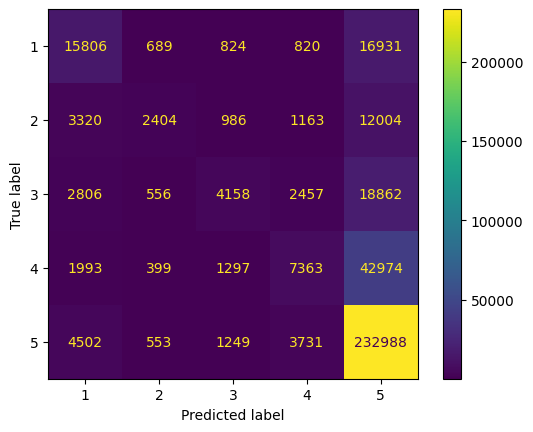

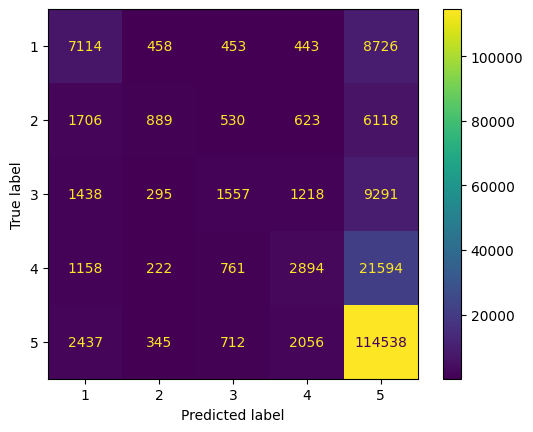


## Binary Classification

In [15]:
w2v_df['Score'] = w2v_df['Score'] > 3
w2v_df.dropna()

X = w2v_df.iloc[:, :-1].values
y = w2v_df.iloc[:, -1].values

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y, test_size=0.33, random_state = 42)

0.1310655119026482


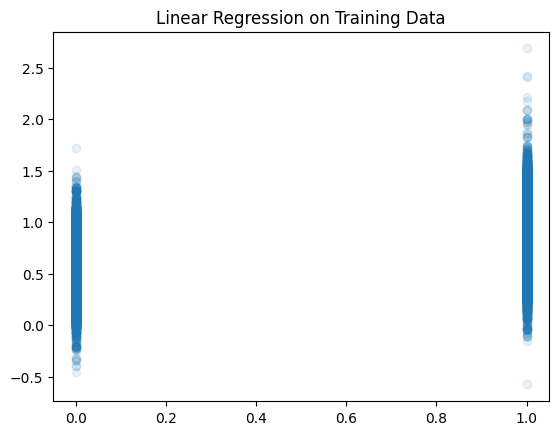

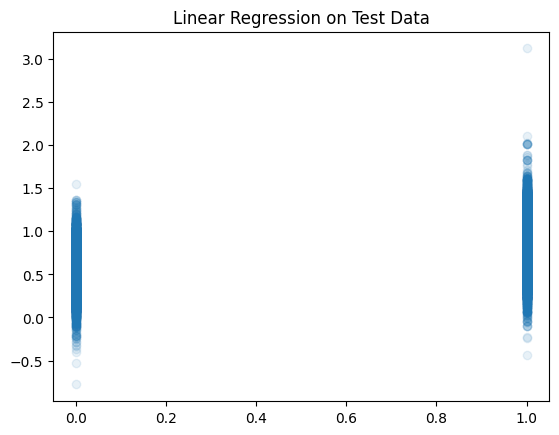

In [16]:
# Linear Regression model
from sklearn.metrics import accuracy_score

reg_bin = LinearRegression()
reg_bin.fit(X_train_bin,y_train_bin)
y_pred_bin = reg_bin.predict(X_test_bin)

y_pred_train_bin = reg_bin.predict(X_train_bin)

MSE = mean_squared_error(y_test_bin, y_pred_bin)
#accuracy = accuracy_score(y_test_w2v, y_pred_w2v)
print(MSE)


#df.Score.hist(bins=5, grid=False)
#plt.show()
plt.scatter(y_train_bin, y_pred_train_bin, alpha = 0.1)
plt.title("Linear Regression on Training Data")
plt.show()

plt.scatter(y_test_bin, y_pred_bin, alpha = 0.1)
plt.title("Linear Regression on Test Data")
plt.show()

0.8176312534652621


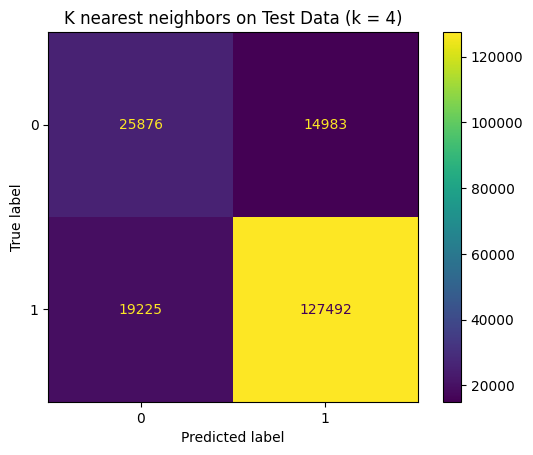

In [17]:
# K Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

k = 4
# k = 4, accuracy = 0.818, took <30 min to run, maybe 22?

neigh_bin = KNeighborsClassifier(n_neighbors=k)
neigh_bin.fit(X_train_bin, y_train_bin)

y_pred_knn_bin = neigh_bin.predict(X_test_bin)

accuracy = accuracy_score(y_test_bin, y_pred_knn_bin)
print(accuracy)

#df.Score.hist(bins=5, grid=False)
#plt.show()

#plt.scatter(y_test_w2v, y_pred_knn, alpha = 0.1)
#plt.show()

cm_test = confusion_matrix(y_test_bin, y_pred_knn_bin, labels=[0,1])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot()
plt.title("K nearest neighbors on Test Data (k = 4)")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 28.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   32.5s finished


Training: 0.9999264773458322, Test: 0.8818718812641276


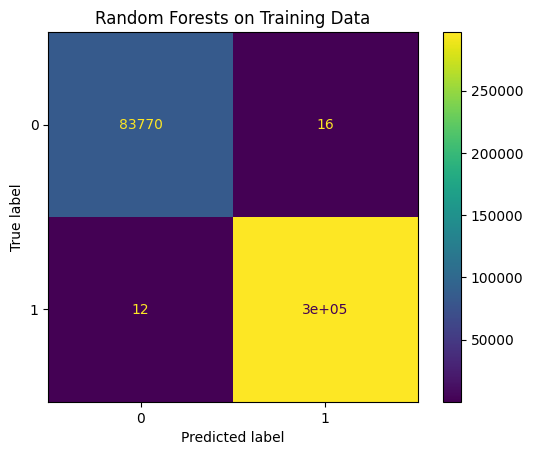

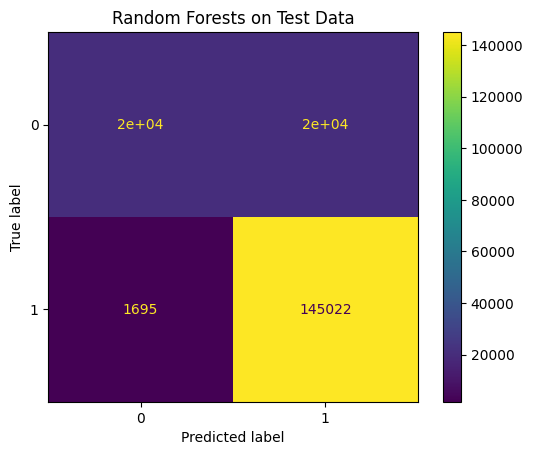

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

forest_bin = RandomForestClassifier(n_estimators = 200, verbose = 1)
# n_estimators = 200, accuracy= 0.88, took about 29 min to run

forest_bin.fit(X_train_bin,y_train_bin)
y_pred_forest_bin = forest_bin.predict(X_test_bin)
y_pred_train_forest_bin = forest_bin.predict(X_train_bin)

train_accuracy = accuracy_score(y_train_bin, y_pred_train_forest_bin)
accuracy = accuracy_score(y_test_bin, y_pred_forest_bin)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

cm_train = confusion_matrix(y_train_bin, y_pred_train_forest_bin, labels=[0,1])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0,1])
disp_train.plot()
plt.title("Random Forests on Training Data")
plt.show()

cm_test = confusion_matrix(y_test_bin, y_pred_forest_bin, labels=[0,1])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot()
plt.title("Random Forests on Test Data")
plt.show()

[02:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

MSE: 0.12249434895722268
Training: 0.9999264773458322, Test: 0.8775056510427773


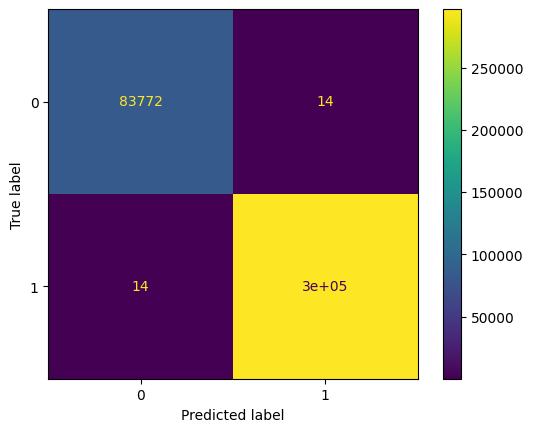

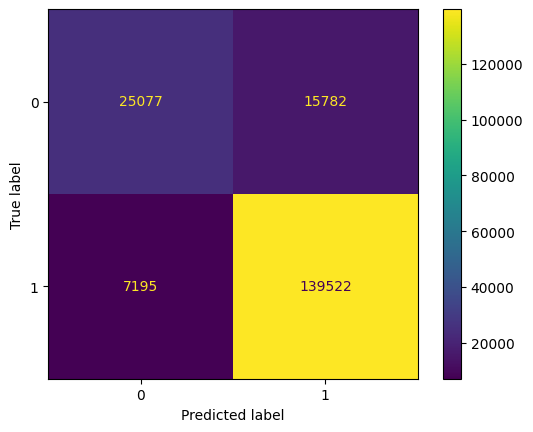

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

bst = XGBClassifier(n_estimators=20, max_depth=50, learning_rate=1, objective='binary:logistic', verbose = 1)

# fit model
# n_estimators=20, max_depth=50: Training: 0.9999264773458322, Test: 0.8775056510427773

bst.fit(X_train_bin, y_train_bin)
# make predictions
y_pred_bin = bst.predict(X_test_bin)
y_pred_train_bst_bin = bst.predict(X_train_bin) 


MSE = mean_squared_error(y_test_bin, y_pred_bin)
print("MSE: " + str(MSE))
train_accuracy = accuracy_score(y_train_bin, y_pred_train_bst_bin)
accuracy = accuracy_score(y_test_bin, y_pred_bin)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

# Plots
cm_train = confusion_matrix(y_train_bin, y_pred_train_bst_bin, labels=[0,1])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0,1])
disp_train.plot()
plt.show()

cm_test = confusion_matrix(y_test_bin, y_pred_bin, labels=[0,1])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot()
plt.show()

# Word2vec on an equal training set

In [ ]:
#https://www.kaggle.com/code/aayushkubba/word2vec-and-random-forest-classification

from gensim.models import Word2Vec, word2vec
import logging
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import re
from tqdm import tqdm


model = Word2Vec(sentences=common_texts, vector_size=50, window=5, min_count=1, workers=4)

list_of_sent=[]
for sent in small_df['Text'].values:
    list_of_sent.append(sent.split())

# Converting words to vectors
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in model.wv:
            vec = model.wv[word]
            sent_vec = sent_vec + vec
            cnt_words +=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

# Putting vectors in database
small_w2v = pd.DataFrame(sent_vectors)
small_w2v['Score'] = small_df['Score'].values.tolist()
small_w2v.dropna()

X = small_w2v.iloc[:, :-1].values
y = small_w2v.iloc[:, -1].values

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, test_size=0.20, random_state = 42)

2.134375


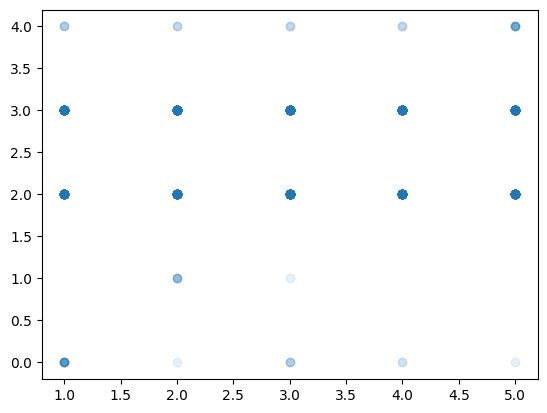

In [ ]:
bst = XGBClassifier(n_estimators=5, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
y_train = y_train_small - 1
bst.fit(X_train_small, y_train)
# make predictions
y_pred_small = bst.predict(X_train_small)

MSE = mean_squared_error(y_train_small, y_pred_small)
print(MSE)

#df.Score.hist(bins=5, grid=False)
#plt.show()

plt.scatter(y_train_small, y_pred_small, alpha = 0.1)
plt.show()

#Doc2Vec

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=20, window=2, min_count=1, workers=4)
model.save("word2vec.model")

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

'\nvector_size = Dimensionality of the feature vectors.\nwindow = The maximum distance between the current and predicted word within a sentence.\nmin_count = Ignores all words with total frequency lower than this.\nalpha = The initial learning rate.\n'

In [22]:
# Making a list of vectors corresponding to list of reviews
list_of_vect = []
for sent in df['Text'].values:
    list_of_sent.append([sent])
    list_of_vect.append(model.infer_vector([sent]))



In [23]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

vec_df = pd.DataFrame(list_of_vect)
vec_df['Score'] = df['Score'].values.tolist()
vec_df.dropna()

X = vec_df.iloc[:, :-1].values
y = vec_df.iloc[:, -1].values

X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.33, random_state = 42)


### Linear Regression

1.714473006442375


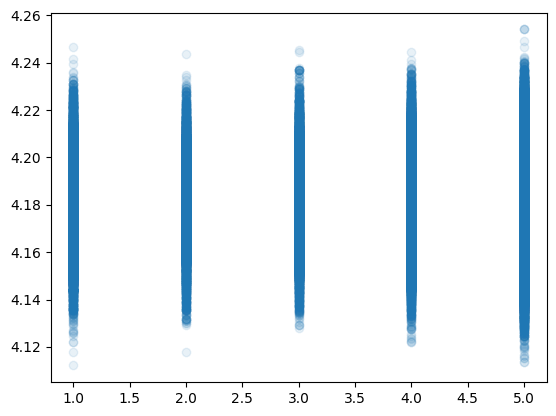

In [ ]:
reg = LinearRegression()
reg.fit(X_train_vec,y_train_vec)
y_pred_vec = reg.predict(X_test_vec)

MSE = mean_squared_error(y_test_vec, y_pred_vec)
print(MSE)

#df.Score.hist(bins=5, grid=False)
#plt.show()

plt.scatter(y_test_vec, y_pred_vec, alpha = 0.1)
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 29.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   44.0s finished


Training: 0.8226082161566033, Test: 0.7448500874312278


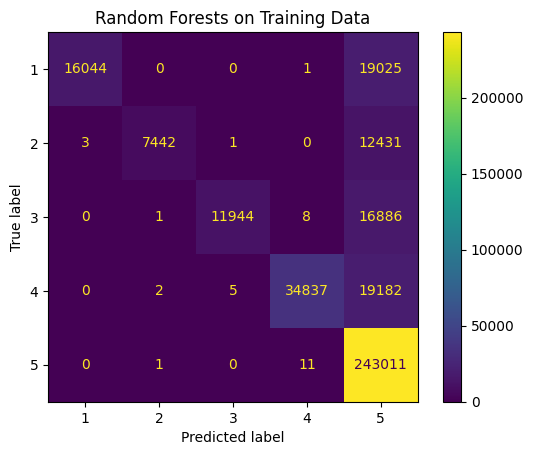

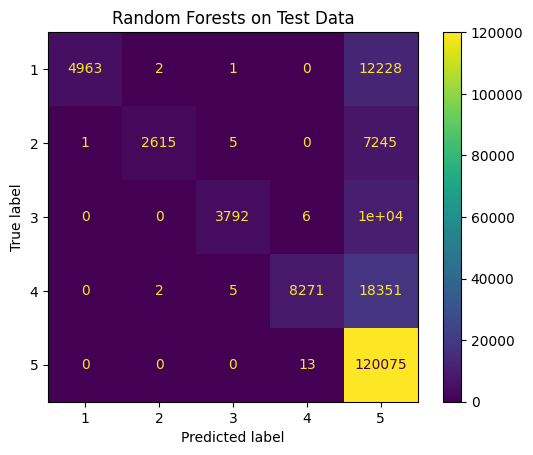

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

forest = RandomForestClassifier(n_estimators = 200, min_samples_split=15, verbose = 1)

forest.fit(X_train_vec,y_train_vec)
y_pred_forest = forest.predict(X_test_vec)
y_pred_train_forest = forest.predict(X_train_vec)

train_accuracy = accuracy_score(y_train_vec, y_pred_train_forest)
accuracy = accuracy_score(y_test_vec, y_pred_forest)
print("Training: " + str(train_accuracy) + ", Test: " + str(accuracy))

cm_train = confusion_matrix(y_train_vec, y_pred_train_forest, labels=[1,2,3,4,5])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[1,2,3,4,5])
disp_train.plot()
plt.title("Random Forests on Training Data")
plt.show()

cm_test = confusion_matrix(y_test_vec, y_pred_forest, labels=[1,2,3,4,5])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[1,2,3,4,5])
disp_test.plot()
plt.title("Random Forests on Test Data")
plt.show()

# VaderSentiment

In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 8.2 MB/s eta 0:00:00


In [ ]:
#VaderSentiment
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

listing = []
for row in tqdm(df['Text']):
    vs = analyzer.polarity_scores(row)
    listing.append(vs)
    
df_results = pd.DataFrame(listing)
df_results.head()

df_with_sent = pd.concat([df.reset_index(drop=True), df_results], axis=1)


df_with_sent['Sentiment'] = np.where(df_results['compound']>=0, 'Positive', 'Negative')
df_with_sent.head()

100%|██████████| 568411/568411 [12:00<00:00, 788.52it/s]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neg,neu,pos,compound,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,0.000,0.711,0.289,0.9441,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0.138,0.862,0.000,-0.5664,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,0.087,0.767,0.146,0.8138,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0.000,0.932,0.068,0.4404,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,0.000,0.599,0.401,0.9468,Positive


1.2227198877673144


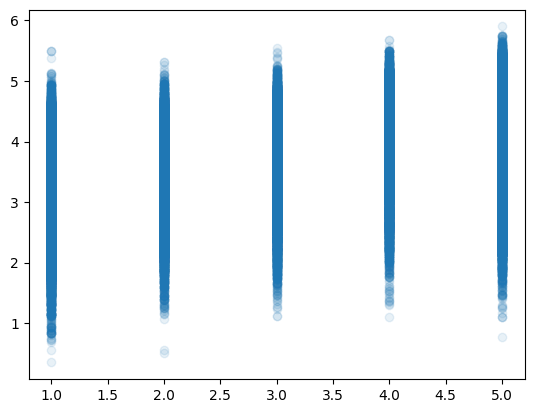

In [ ]:
sentiment_df = df_with_sent[["pos", "neg", "neu", "compound","Score"]] 

X = sentiment_df.iloc[:, :-1].values
y = sentiment_df.iloc[:, -1].values

X_train_vader, X_test_vader, y_train_vader, y_test_vader = train_test_split(X, y, test_size=0.33, random_state = 42)


reg = LinearRegression()
reg.fit(X_train_vader,y_train_vader)
y_pred_vader = reg.predict(X_test_vader)

MSE = mean_squared_error(y_test_vader, y_pred_vader)
print(MSE)

#df.Score.hist(bins=5, grid=False)
#plt.show()

plt.scatter(y_test_vader, y_pred_vader, alpha = 0.1)
plt.show()

## KNNs

1.6874653473791956


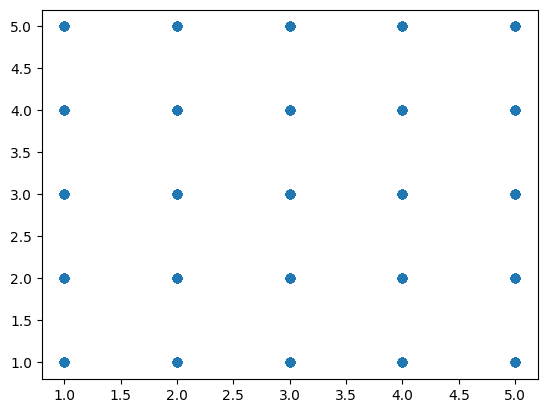

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 4

# on vader parameters
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_vader, y_train_vader)

y_pred_vader_knn = neigh.predict(X_test_vader)

MSE = mean_squared_error(y_test_vader, y_pred_vader_knn)
print(MSE)

#df.Score.hist(bins=5, grid=False)
#plt.show()

plt.scatter(y_test_vader, y_pred_vader_knn, alpha = 0.1)
plt.show()

In [ ]:
k = 10

# on vector parameters
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_vec, y_train_vec)

y_pred_vec_knn = neigh.predict(X_test_vec)

MSE = mean_squared_error(y_test_vec, y_pred_vec_knn)
print(MSE)

#df.Score.hist(bins=5, grid=False)
#plt.show()

plt.scatter(y_test_vec, y_pred_vec_knn, alpha = 0.1)
plt.show()

## Second word2vec

In [ ]:
reviews = pd.read_csv('Reviews.csv')

# Lowercase
reviews['Text'] = reviews['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Remove punctuation
reviews['Text'] = reviews['Text'].str.replace('[^\w\s]', "")
#reviews['Text'].head()

train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]



<ipython-input-45-00c3238292a7>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['Text'] = reviews['Text'].str.replace('[^\w\s]', "")
